In [1]:
#import required package
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import spectral.io.envi as envi
import os
import re
import math
from scipy import signal
from scipy import ndimage
from scipy import spatial
from scipy import stats
from scipy import interpolate
import traceback
import sys
import pickle
import warnings
import pandas as pd
from pprint import pprint
from sklearn.preprocessing import minmax_scale
from PIL import Image

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#file mangement generates a list containing a pth to all hdr files of pre-processed observations
def get_all_processed_HDR_addresses(parentDirectory):
    observationFiles=[]
    
    for (dirpath, dirnames, filenames) in os.walk(parentDirectory):
        observationFiles.extend(filenames)
        break
    ObservationImageAddresses=[]
    
    hdrPattern=".hdr"
    for i in observationFiles:
        if re.search(hdrPattern,i):
            ObservationImageAddresses.append(parentDirectory+'/'+i)
    return ObservationImageAddresses

In [3]:
#read hrd files for wavlengths of all bands
def read_CRISM_Image_wavelengths(headerFileAddress):
    wavelengthFile="J:/IIT/user/Documents/CRISM Multispectral Exploration/Processed_observations/wavelength_list.txt"
    
    currentObservationHeader=envi.open(headerFileAddress)
    currentObservationImage=currentObservationHeader.open_memmap()
    currentObservationArray=np.array(currentObservationImage)
    #currentObservationArray=spectral.open_image(i)

    #read wavelengths from saved wavelength file
    with open (wavelengthFile, 'rb') as fp:
        wavelengthsOfCurrentObservation=pickle.load(fp)
    return currentObservationArray,wavelengthsOfCurrentObservation

In [4]:
#find index of wavelngth closest to given wavelength
def find_nearest(wavelength_list,value): #find wavelength value in list closest to given value
    idx = np.searchsorted(wavelength_list, value, side="left")
    if idx > 0 and (idx == len(wavelength_list) or math.fabs(value - wavelength_list[idx-1]) < math.fabs(value - wavelength_list[idx])):
        return wavelength_list[idx-1]
    else:
        return wavelength_list[idx]

def find_wavelength_index(wavelength_list,item): #return index of in the array
    first = 0
    last = len(wavelength_list)-1
    found = False
    while( first<=last and not found):
        mid = (first + last)//2
        if wavelength_list[mid] == item :
            found = True
        else:
            if item < wavelength_list[mid]:
                last = mid - 1
            else:
                first = mid + 1	
    return mid
def find_nearest_index(wavelength_list,wavelength): #get wavelength in index closest to gicen wavelength and return its index
    (nearest_index,nearest_wavelength)=min(enumerate(wavelength_list), key=lambda x: abs(x[1]-wavelength))
    return nearest_index
def find_nearest_index_for_list(wavelength_list,wavelengths): # find index of nearest value for a list of given values
    indices=[]
    for i in wavelengths:
        indices.append(find_nearest_index(wavelength_list,i))
    return indices

In [5]:
# given a hyperspectral datacube and wavelengths to serve as upper and lower thresholds subset the datacube along the spectral direction
def get_spectral_subset(datacube,wavelength_list,lower_threshold,upper_threshold): #returns spectral subset from lower to upper threshold ( 1.2 to 2.6 micrometer for CRISM IR)
    lower_threshold_index=find_wavelength_index(wavelength_list,lower_threshold)
    upper_threshold_index=find_wavelength_index(wavelength_list,upper_threshold)
    thresholdedDatacube=datacube[:,:,lower_threshold_index:upper_threshold_index+1]
    thresholdedWavelengthList=wavelength_list[lower_threshold_index:upper_threshold_index+1]
    return thresholdedDatacube,thresholdedWavelengthList

In [6]:
#given a spectral object and a wavelength list extract spectra resample them to the given wavelenght list resolution
def getResampledSpectra(spectralObject,wavelengthList):
    #read an NxM numpy array containing N spectra with M bands
    spectras=spectralObject.spectra 
    #read an array with wavelengths corresponding to each band
    sourceWavelengthList=spectralObject.bands.centers 
    #find no of bands in CRISM image
    noOfBands=np.shape(wavelengthList)[0] 
    # calculate number of spectras
    noOfSpectra=np.shape(spectras)[0]
    # create an array to store the resampled spectras
    resampledSpectras=np.zeros((noOfSpectra,noOfBands))
    #create a resampler
    resampler=BandResampler(sourceWavelengthList,wavelengthList)
    #iterate over all spectra
    for i in range(noOfSpectra):
        #resample a spectra
        resampledSpectras[i,:]=resampler(spectras[i,:])
    return resampledSpectras,spectralObject.names

In [7]:
#given spectral object get original spectra and accompaning wavelength list
def getOriginalSpectra(spectralObject):
    #read an NxM numpy array containing N spectra with M bands
    spectras=spectralObject.spectra 
    #read an array with wavelengths corresponding to each band
    sourceWavelengthList=spectralObject.bands.centers 
    
    return spectras,spectralObject.names,sourceWavelengthList

In [8]:
# threshold image at 2.6 micrometer
def preProcessImage(imageHeaderAddress): # given address of a CRISM header file, read the data, deal with NaN values and apply spectral subset
    datacube,wavelength_list=read_CRISM_Image_wavelengths(imageHeaderAddress) #read image and wavelength_list
    datacube=np.where(np.logical_and(datacube>0,datacube<1),datacube,0)
    lower_threshold_for_spectral_subset=1.0
    upper_threshold_for_spectral_subset=2.59 #define wavelength threshold (CRISM data too noisy post 2.6 micrometer)
    datacube,wavelength_list=get_spectral_subset(datacube,wavelength_list,lower_threshold_for_spectral_subset,upper_threshold_for_spectral_subset)
    return datacube,wavelength_list

In [9]:
#calculate mean relfectance at wavelength with defined kernel size for datacube
def calcualteReflectaneAtWavelength(wavelength,kernelSize):
    global slicedCube
    global wavelengthList
    targetWavelength=find_nearest(wavelengthList,wavelength) #find nearest wavelength value in list
    targetWavelengthIndex=find_nearest_index(wavelengthList,wavelength) 
    BandAtWavelength=slicedCube[:,:,targetWavelengthIndex]
    for i in range(targetWavelengthIndex-math.floor(kernelSize/2),targetWavelengthIndex+math.floor(kernelSize/2)):
        BandAtWavelength=np.add(slicedCube[:,:,i],BandAtWavelength)
    BandAtWavelength=np.subtract(BandAtWavelength,slicedCube[:,:,targetWavelengthIndex])
    return BandAtWavelength/kernelSize

In [10]:
#given a spectra normalize it to the range (0,1)
def normalizeSpectra(spectra):
    upperLimit=1
    lowerLimit=0.0000001
    maximumValue=np.amax(spectra)
    minimumValue=np.amin(spectra)
    normalizedSpectra=(upperLimit-lowerLimit)*(spectra-minimumValue)/(maximumValue-minimumValue)+lowerLimit
    return normalizedSpectra

In [11]:
#calculate mean relfectance at wavelength with defined kernel size 
def calcualteReflectaneAtWavelength(wavelength,kernelSize):
    global slicedCube
    global wavelengthList
    targetWavelength=find_nearest(wavelengthList,wavelength) #find nearest wavelength value in list
    targetWavelengthIndex=find_nearest_index(wavelengthList,wavelength) 
    BandAtWavelength=slicedCube[:,:,targetWavelengthIndex]
    for i in range(targetWavelengthIndex-math.floor(kernelSize/2),targetWavelengthIndex+math.floor(kernelSize/2)):
        BandAtWavelength=np.add(slicedCube[:,:,i],BandAtWavelength)
    BandAtWavelength=np.subtract(BandAtWavelength,slicedCube[:,:,targetWavelengthIndex])
    return BandAtWavelength/kernelSize

In [12]:
#calculate band depth based indices for Fe and Ca/Mg rich carbonates
def calculateMIN23AND25():
    
    global datacube
    global wavelengthList
    
    R2345Wavelength=2.345 #define constant values to calculate indices, wavelengths, and kernel size 
    R2250Wavelength=2.250
    R2430Wavelength=2.430
    R2537Wavelength=2.537
    R2602Wavelength=2.590#2.602

    R2345KernelSize=5
    R2250KernelSize=5
    R2430KernelSize=5
    R2602KernelSize=1
    R2537KernelSize=5

    R2295Wavelength=2.295
    R2165Wavelength=2.165
    R2364Wavelength=2.364
    R2480Wavelength=2.480
    R2570Wavelength=2.570

    R2295KernelSize=5
    R2165KernelSize=5
    R2364KernelSize=5
    R2480KernelSize=5
    R2570KernelSize=5


    bForR2430=(R2345Wavelength-R2250Wavelength)/(R2430Wavelength-R2250Wavelength)
    aForR2250=1-bForR2430
    bForR2602=(R2537Wavelength-R2430Wavelength)/(R2602Wavelength-R2430Wavelength)
    aForR2430=1-bForR2602

    bForR2364=(R2295Wavelength-R2165Wavelength)/(R2364Wavelength-R2165Wavelength)
    aForR2165=1-bForR2364
    bForR2570=(R2480Wavelength-R2364Wavelength)/(R2570Wavelength-R2364Wavelength)
    aForR2364=1-bForR2570
    
    
    R2295Reflectance=calcualteReflectaneAtWavelength(R2295Wavelength,R2295KernelSize) #read bands corresponding to wavelengths
    R2165Reflectance=calcualteReflectaneAtWavelength(R2165Wavelength,R2165KernelSize)
    R2364Reflectance=calcualteReflectaneAtWavelength(R2364Wavelength,R2364KernelSize)
    R2480Reflectance=calcualteReflectaneAtWavelength(R2480Wavelength,R2480KernelSize)
    R2570Reflectance=calcualteReflectaneAtWavelength(R2570Wavelength,R2570KernelSize)

    temp1Den=np.add(aForR2165*R2165Reflectance,bForR2364*R2364Reflectance) # calculation for MIN2295_2480 minimum band depth at 2.3 and 2.5 micrometer 
    temp2Den=np.add(aForR2364*R2364Reflectance,bForR2570*R2570Reflectance)
    temp3=np.full_like(R2570Reflectance,2.0)
    
    temp1=np.divide(R2295Reflectance,temp1Den,temp3,where=np.logical_and(temp2Den>0,temp2Den<1))
    temp1=np.subtract(np.full_like(R2570Reflectance,1),temp1)
    temp3=np.full_like(R2570Reflectance,2.0)
    temp2=np.divide(R2480Reflectance,temp2Den,temp3,where=np.logical_and(temp2Den>0,temp2Den<1))
    temp2=np.subtract(np.full_like(R2570Reflectance,1),temp2)
    MIN2295_2480=np.minimum(temp1,temp2)
    
    R2345Reflectance=calcualteReflectaneAtWavelength(R2345Wavelength,R2345KernelSize) #read bands corresponding to wavelengths
    R2250Reflectance=calcualteReflectaneAtWavelength(R2250Wavelength,R2250KernelSize)
    R2430Reflectance=calcualteReflectaneAtWavelength(R2430Wavelength,R2430KernelSize)
    R2537Reflectance=calcualteReflectaneAtWavelength(R2537Wavelength,R2537KernelSize)
    R2602Reflectance=calcualteReflectaneAtWavelength(R2602Wavelength,R2602KernelSize)
    
    temp1Den=np.add(aForR2250*R2250Reflectance,bForR2430*R2430Reflectance) # calculation for MIN2345_2537 minimum band depth at 2.33 and 2.53 micrometer
    temp2Den=np.add(aForR2430*R2250Reflectance,bForR2602*R2602Reflectance)
    temp3=np.full_like(R2345Reflectance,2.0)
    
    temp1=np.divide(R2345Reflectance,temp1Den,temp3,where=np.logical_and(temp2Den>0,temp2Den<1))
    temp1=np.subtract(np.full_like(R2345Reflectance,1),temp1)
    temp3=np.full_like(R2345Reflectance,2.0)
    temp2=np.divide(R2537Reflectance,temp2Den,temp3,where=np.logical_and(temp2Den>0,temp2Den<1))
    temp2=np.subtract(np.full_like(R2345Reflectance,1),temp2)
    MIN2345_2537=np.minimum(temp1,temp2)
    
    return MIN2295_2480,MIN2345_2537

In [13]:
#create a function to calculate CINDEX2
def calcCINDEX2():
    #get datacube and wavelength List
    global datcube
    global wavelengthList
    
    #define the wavelengths for the parameters
    R3450Wavelength=3.450
    R3875Wavelength=3.875
    R3610Wavelength=3.610
    
    #define the kernel size for smoothing at the wavelengths
    R3450KernelSize=9
    R3610KernelSize=11
    R3875KernelSize=7
    
    #define constants to calculate inverse band-depth
    b=(R3610Wavelength-R3450Wavelength)/(R3875Wavelength-R3610Wavelength)
    a=1-b
    
    #get reflectances at the right wavelengths
    R3450Reflectance=calcualteReflectaneAtWavelength(R3450Wavelength,R3450KernelSize)
    R3875Reflectance=calcualteReflectaneAtWavelength(R3875Wavelength,R3875KernelSize)
    R3610Reflectance=calcualteReflectaneAtWavelength(R3610Wavelength,R3610KernelSize)
    
    cindex2=1-(a*R3450Reflectance+b*R3875Reflectance)/R3610Reflectance
    return cindex2

In [14]:
#create a function to calculate CINDEX2
def calcOLINDEX3():
    #get datacube and wavelength List
    global datacube
    global wavelengthList
    
    #define the anchor wavelengths
    R2400Wavelength=2.400
    R1750Wavelength=1.750
    
    #store them in an array
    wavelengthsToSample=[1.080,1.152,1.210,1.250,1.263,1.276,1.330,1.368,1.395,1.427,1.470]
    #define the weights for each wavelegnth
    wavelengthWeights=[0.03,0.03,0.03,0.03,0.07,0.07,0.12,0.12,0.14,0.18,0.18]

    #define the kernel size for smoothing at the wavelengths
    wavelengthKernels=[1,1,7,7,7,7,7,1,1,1,1]
    R1750KernelSize=7
    R2400KernelSize=7
    
    #create an array to hold OLINDEX2
    OLINDEX3=np.zeros_like(datacube[:,:,0])
    
    #get reflectance at the anchors
    
    R1750Reflectance=calcualteReflectaneAtWavelength(R1750Wavelength,R1750KernelSize)
    R2400Reflectance=calcualteReflectaneAtWavelength(R2400Wavelength,R2400KernelSize)
    
    #iterate through all sample wavlengths to calculate the parameter
    for i in range(len(wavelengthKernels)):
        #get the current band
        rIReflectance=calcualteReflectaneAtWavelength(wavelengthsToSample[i],wavelengthKernels[i])
        #calcuate the parameters
        b=(R2400Wavelength-wavelengthsToSample[i])/(R2400Wavelength-R1750Wavelength)
        a=1-b
        #get current band depth
        bd=((a*R1750Reflectance+b*R2400Reflectance)-rIReflectance)/(a*R1750Reflectance+b*R2400Reflectance)
        #weight and add the band depth
        OLINDEX3=OLINDEX3+bd*wavelengthWeights[i]
    return OLINDEX3

In [15]:
#create a function to calculate D2300
def calcD2300():
    #get datacube and wavelength List
    global datacube
    global wavelengthList
    
    #define the anchor wavelengths
    R2530Wavelength=2.530
    R1815Wavelength=1.815
    
    #store them in an array
    numeratorWavelengths=[2.290,2.320,2.330]
    denominatorWavelengths=[2.120,2.170,2.210]
    #define the weights for each wavelegnth
    #define the kernel size for smoothing at the wavelengths
    numeratorKernels=[3,3,3]
    denominatorKernels=[5,5,5]
    R1851KernelSize=5
    R2530KernelSize=5
    
    #create an array to hold numberator
    D2300N=np.zeros_like(datacube[:,:,0])
    
    #get reflectance at the anchors
    R1815Reflectance=calcualteReflectaneAtWavelength(R1815Wavelength,R1851KernelSize)
    R2530Reflectance=calcualteReflectaneAtWavelength(R2530Wavelength,R2530KernelSize)
    
    #iterate through all numberators wavlengths
    for i in range(len(numeratorWavelengths)):
        #get the current band
        rIReflectance=calcualteReflectaneAtWavelength(numeratorWavelengths[i],numeratorKernels[i])
        #calcuate the parameters
        b=(R2530Wavelength-numeratorWavelengths[i])/(R2530Wavelength-R1815Wavelength)
        a=1-b
        #weight and add the band depth
        D2300N=D2300N+rIReflectance/(a*R1815Reflectance+b*R2530Reflectance)
    
    #create an array to hold numberator
    D2300D=np.zeros_like(datacube[:,:,0])
    #iterate through all numberators wavlengths
    for i in range(len(denominatorWavelengths)):
        #get the current band
        rIReflectance=calcualteReflectaneAtWavelength(denominatorWavelengths[i],denominatorKernels[i])
        #calcuate the parameters
        b=(R2530Wavelength-denominatorWavelengths[i])/(R2530Wavelength-R1815Wavelength)
        a=1-b
        #weight and add the band depth
        D2300D=D2300D+rIReflectance/(a*R1815Reflectance+b*R2530Reflectance)
    #calculate the parameter
    return 1-(D2300N/D2300D)

In [16]:
#create a function to calculate BD2500H
def calcBD2500_2():
    #get datacube and wavelength List
    global datacube
    global wavelengthList
    
    #define the wavelengths for the parameters
    R2480Wavelength=2.480
    R2364Wavelength=2.364
    R2570Wavelength=2.570
    
    #define the kernel size for smoothing at the wavelengths
    R2570KernelSize=1
    R2364KernelSize=1
    R2480KernelSize=1
    
    #define constants to calculate inverse band-depth
    b=(R2570Wavelength-R2480Wavelength)/(R2570Wavelength-R2364Wavelength)
    a=1-b
    #get reflectances at the right wavelengths
    R2480Reflectance=calcualteReflectaneAtWavelength(R2480Wavelength,R2480KernelSize)
    R2364Reflectance=calcualteReflectaneAtWavelength(R2364Wavelength,R2364KernelSize)
    R2570Reflectance=calcualteReflectaneAtWavelength(R2570Wavelength,R2570KernelSize)
    BD2500_2=1-R2480Reflectance/(a*R2364Reflectance+b*R2570Reflectance)
    return BD2500_2

In [17]:
#given a datacube return its footprint i.e pixels in and out of the scene
def getDatacubeFootprint(datacube):
    [row,col,bands]=np.shape(datacube)
    #create an array to hold footprint of the image
    footprint=np.zeros_like(datacube[:,:,0])
    #get foot print of in scene pixels
    for i in range(row):
        for j in range(col):
            if 0==datacube[i,j,:].all():
                footprint[i,j]=1
    return footprint

In [52]:
headerFileAddress="G:/0003E12/frt00003e12_07_if166l_trr3_CAT_corr_p.hdr"
print(headerFileAddress)
#datacube,wavelengthList=preProcessImage(i) #get sliced datacube and list of wavelengths corresponding to bands

currentObservationHeader=envi.open(headerFileAddress)
currentObservationImage=currentObservationHeader.open_memmap()
datacube=np.array(currentObservationImage)
wavelengthList=np.array(currentObservationHeader.bands.centers)
slicedCube=datacube
#get teh footprint of the image
imageFootprint=np.full_like(datacube[:,:,0],1)
[rows,cols,bands]=np.shape(datacube)
for i in range(rows):
    for j in range(cols):
        if (all(v == datacube[i,j,0] for v in datacube[i,j,:])):
            imageFootprint[i,j]=-1



G:/0003E12/frt00003e12_07_if166l_trr3_CAT_corr_p.hdr


FileNotFoundError: Unable to locate file "G:/0003E12/frt00003e12_07_if166l_trr3_CAT_corr_p.hdr". If the file exists, use its full path or place its directory in the SPECTRAL_DATA environment variable.

In [48]:
#calculate MIN indices
MIN2295_2480,MIN2345_2537=calculateMIN23AND25()
#calculate CINDEX2
CINDEX2=calcCINDEX2()
#calculate OLINDEX3
OLINDEX3=calcOLINDEX3()
#calculate D2300
D2300=calcD2300()
#calculate BD2500_2
BD2500_2=calcBD2500_2()
#calculate BD1900_2

C:\Users\104D\AppData\Local\Temp/ipykernel_27292/33149049.py:24: RuntimeWarning: invalid value encountered in true_divide
  BD2500_2=1-R2480Reflectance/(a*R2364Reflectance+b*R2570Reflectance)


In [49]:

#remote no-data and NaN values
MIN2295_2480[imageFootprint==-1]=np.nan
MIN2345_2537[imageFootprint==-1]=np.nan
CINDEX2[imageFootprint==-1]=np.nan
OLINDEX3[imageFootprint==-1]=np.nan
D2300[imageFootprint==-1]=np.nan
BD2500_2[imageFootprint==-1]=np.nan

In [50]:
#scale all images between 0 and 1
MIN2295_2480=(MIN2295_2480-np.amin(MIN2295_2480[imageFootprint!=-1]))/np.ptp(MIN2295_2480[imageFootprint!=-1])
MIN2345_2537=(MIN2345_2537-np.amin(MIN2345_2537[imageFootprint!=-1]))/np.ptp(MIN2345_2537[imageFootprint!=-1])
CINDEX2=(CINDEX2-np.amin(CINDEX2[imageFootprint!=-1]))/np.ptp(CINDEX2[imageFootprint!=-1])
OLINDEX3=(OLINDEX3-np.amin(OLINDEX3[imageFootprint!=-1]))/np.ptp(OLINDEX3[imageFootprint!=-1])
D2300=(D2300-np.amin(D2300[imageFootprint!=-1]))/np.ptp(D2300[imageFootprint!=-1])
BD2500_2=(BD2500_2-np.amin(BD2500_2[imageFootprint!=-1]))/np.ptp(BD2500_2[imageFootprint!=-1])

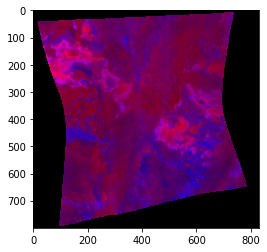

In [51]:
#create RGB
rgbComposite=np.dstack([OLINDEX3,BD2500_2,D2300])
plt.imshow(rgbComposite)

In [24]:
#threshold for only positive values
MIN2295_2480[MIN2295_2480<0]=0
MIN2345_2537[MIN2345_2537<0]=0
CINDEX2[CINDEX2<0]=0
OLINDEX3[OLINDEX3<0]=0
D2300[D2300<0]=0

In [25]:
#threshold for MICA values
MIN2295_2480[MIN2295_2480<0]=0
MIN2345_2537[MIN2345_2537<0]=0
CINDEX2[CINDEX2<0]=0
OLINDEX3[OLINDEX3<0.186]=0.186
D2300[D2300<0]=0

In [28]:
#set quantiles to scale
quantileValues=[0.02,0.99]
#get 2 and 98th quantile
limitThresholdsMIN2295_2480=np.quantile(MIN2295_2480,quantileValues)
limitThresholdsMIN2345_2537=np.quantile(MIN2345_2537,quantileValues)
limitThresholdsCINDEX2=np.quantile(CINDEX2,quantileValues)
limitThresholdsOLINDEX3=np.quantile(OLINDEX3,quantileValues)
limitThresholdsD2300=np.quantile(D2300,quantileValues)
#specify thersholds from MICA
'''limitThresholdsMIN2295_2480=[0,0.0001]
limitThresholdsMIN2345_2537=[0,0.0009]
limitThresholdsCINDEX2=[0,0.0206]
limitThresholdsOLINDEX3=[0.186,0.336]
limitThresholdsD2300=np.quantile(D2300,quantileValues)'''
#stretch the image
MIN2295_2480[np.where(MIN2295_2480<=limitThresholdsMIN2295_2480[0])]=limitThresholdsMIN2295_2480[0]
MIN2295_2480[np.where(MIN2295_2480>=limitThresholdsMIN2295_2480[1])]=limitThresholdsMIN2295_2480[1]

MIN2345_2537[np.where(MIN2345_2537<=limitThresholdsMIN2345_2537[0])]=limitThresholdsMIN2345_2537[0]
MIN2345_2537[np.where(MIN2345_2537>=limitThresholdsMIN2345_2537[1])]=limitThresholdsMIN2345_2537[1]

CINDEX2[np.where(CINDEX2<=limitThresholdsCINDEX2[0])]=limitThresholdsCINDEX2[0]
CINDEX2[np.where(CINDEX2>=limitThresholdsCINDEX2[1])]=limitThresholdsCINDEX2[1]

OLINDEX3[np.where(OLINDEX3<=limitThresholdsOLINDEX3[0])]=limitThresholdsOLINDEX3[0]
OLINDEX3[np.where(OLINDEX3>=limitThresholdsOLINDEX3[1])]=limitThresholdsOLINDEX3[1]

D2300[np.where(D2300<=limitThresholdsD2300[0])]=limitThresholdsD2300[0]
D2300[np.where(D2300>=limitThresholdsD2300[1])]=limitThresholdsD2300[1]



In [29]:
MIN2295_2480[imageFootprint==-1]=np.nan
MIN2345_2537[imageFootprint==-1]=np.nan
CINDEX2[imageFootprint==-1]=np.nan
OLINDEX3[imageFootprint==-1]=np.nan
D2300[imageFootprint==-1]=np.nan


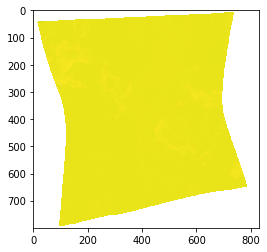

In [30]:
#plt.imshow(CINDEX2)
plt.imshow(MIN2295_2480)

In [91]:
#stretch the

In [32]:
#scale all values between 0 and 1
minimum=OLINDEX3[imageFootprint!=-1].min()
maximum=OLINDEX3[imageFootprint!=-1].max()
OLINDEX3[imageFootprint==-1]=minimum
OLINDEX3=(OLINDEX3-minimum)/(maximum-minimum)
OLINDEX3=OLINDEX3*255.999

minimum=MIN2295_2480[imageFootprint!=-1].min()
maximum=MIN2295_2480[imageFootprint!=-1].max()
MIN2295_2480[imageFootprint==-1]=minimum
MIN2295_2480=(MIN2295_2480-minimum)/(maximum-minimum)
MIN2295_2480=MIN2295_2480*255.999

minimum=MIN2345_2537[imageFootprint!=-1].min()
maximum=MIN2345_2537[imageFootprint!=-1].max()
MIN2345_2537[imageFootprint==-1]=minimum
MIN2345_2537=(MIN2345_2537-minimum)/(maximum-minimum)
MIN2345_2537=MIN2345_2537*255.999

minimum=CINDEX2[imageFootprint!=-1].min()
maximum=CINDEX2[imageFootprint!=-1].max()
CINDEX2[imageFootprint==-1]=minimum
CINDEX2=(CINDEX2-minimum)/(maximum-minimum)
CINDEX2=CINDEX2*255.999

minimum=D2300[imageFootprint!=-1].min()
maximum=D2300[imageFootprint!=-1].max()
D2300[imageFootprint==-1]=minimum
D2300=(D2300-minimum)/(maximum-minimum)
D2300=D2300*255.999

In [33]:
MIN2295_2480[imageFootprint==-1]=MIN2295_2480.max()
MIN2345_2537[imageFootprint==-1]=MIN2345_2537.max()
CINDEX2[imageFootprint==-1]=CINDEX2.max()
OLINDEX3[imageFootprint==-1]=OLINDEX3.max()
D2300[imageFootprint==-1]=D2300.max()

In [93]:
MIN2295_2480[imageFootprint==-1]=np.nan
MIN2345_2537[imageFootprint==-1]=np.nan
CINDEX2[imageFootprint==-1]=np.nan
OLINDEX3[imageFootprint==-1]=np.nan
D2300[imageFootprint==-1]=np.nan


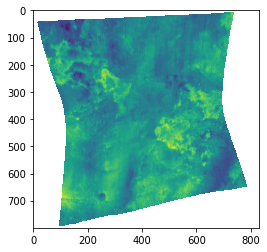

In [33]:
#plt.imshow(CINDEX2)
plt.imshow(CINDEX2)

(array([2.00000e+00, 7.00000e+00, 8.00000e+00, 3.40000e+01, 1.63000e+02,
        4.07500e+03, 1.90988e+05, 1.72397e+05, 2.43100e+03, 4.40000e+01]),
 array([-0.05555093, -0.04882215, -0.04209337, -0.03536459, -0.02863581,
        -0.02190703, -0.01517825, -0.00844947, -0.00172069,  0.00500809,
         0.01173687], dtype=float32),
 <BarContainer object of 10 artists>)

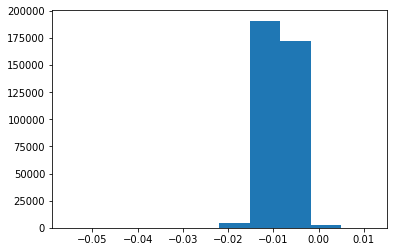

In [76]:
plt.hist(MIN2295_2480[imageFootprint!=-1])

(array([  137.,  2441., 13721., 41360., 78946., 95213., 89140., 42395.,
         6451.,   345.]),
 array([-0.04456902, -0.02123368,  0.00210166,  0.025437  ,  0.04877234,
         0.07210767,  0.09544301,  0.11877835,  0.14211369,  0.16544902,
         0.18878436], dtype=float32),
 <BarContainer object of 10 artists>)

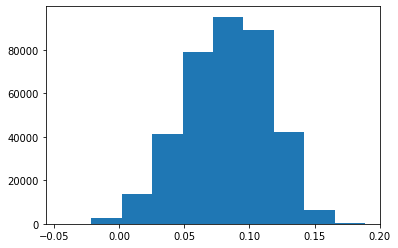

In [46]:
plt.hist(CINDEX2[imageFootprint!=-1])

In [77]:
headerFileAddress="G:/0000A546/0000A546.hdr"
print(headerFileAddress)
#datacube,wavelengthList=preProcessImage(i) #get sliced datacube and list of wavelengths corresponding to bands

currentObservationHeader=envi.open(headerFileAddress)
currentObservationImage=currentObservationHeader.open_memmap()
datacube=np.array(currentObservationImage)
wavelengthList=np.array(currentObservationHeader.bands.centers)
slicedCube=datacube
#get teh footprint of the image
imageFootprint=np.full_like(datacube[:,:,0],1)
[rows,cols,bands]=np.shape(datacube)
for i in range(rows):
    for j in range(cols):
        if (all(v == datacube[i,j,0] for v in datacube[i,j,:])):
            imageFootprint[i,j]=-1



G:/0000A546/0000A546.hdr


In [81]:
wavelengthFile="J:/IIT/user/Documents/CRISM Multispectral Exploration/Processed_observations/wavelength_list.txt"
with open (wavelengthFile, 'rb') as fp:
        wavelengthList=pickle.load(fp)

In [92]:
#calculate MIN indices
MIN2295_2480,MIN2345_2537=calculateMIN23AND25()
#calculate OLINDEX3
OLINDEX3=calcOLINDEX3()
#calculate D2300
D2300=calcD2300()
#calculate BD2500_2
BD2500_2=calcBD2500_2()
#calculate BD1900_2

C:\Users\104D\AppData\Local\Temp/ipykernel_4112/3845342743.py:37: RuntimeWarning: invalid value encountered in true_divide
  bd=((a*R1750Reflectance+b*R2400Reflectance)-rIReflectance)/(a*R1750Reflectance+b*R2400Reflectance)
C:\Users\104D\AppData\Local\Temp/ipykernel_4112/1084437762.py:36: RuntimeWarning: invalid value encountered in true_divide
  D2300N=D2300N+rIReflectance/(a*R1815Reflectance+b*R2530Reflectance)
C:\Users\104D\AppData\Local\Temp/ipykernel_4112/1084437762.py:48: RuntimeWarning: invalid value encountered in true_divide
  D2300D=D2300D+rIReflectance/(a*R1815Reflectance+b*R2530Reflectance)
C:\Users\104D\AppData\Local\Temp/ipykernel_4112/33149049.py:24: RuntimeWarning: invalid value encountered in true_divide
  BD2500_2=1-R2480Reflectance/(a*R2364Reflectance+b*R2570Reflectance)


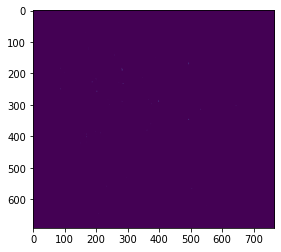

In [86]:
plt.imshow(MIN2295_2480)